### Siddhesh Maheshwari MDS202347 <br> Narendra C MDS202336 <br>  Gauranga Kumar Baishya MDS202325

---

<h1 align = 'center'>
Advanced Machine Learning           </h1>
<h1 align = 'center'>
Assignment 03  </h1>

## **Project Report: Training and Evaluation of a Reinforcement Learning Agent**

---

### **1. Introduction**

Reinforcement learning (RL) is a machine learning paradigm where an agent learns to make decisions by interacting with an environment. In this project, we implemented, trained, and evaluated a Deep Q-Learning (DQN) agent to solve a task, comparing its performance against a random agent. The task involved interacting with an environment to maximize cumulative rewards by choosing optimal actions. The trained agent was evaluated for its ability to improve over time in terms of rewards, efficiency, and decision-making accuracy.

### **2. Objectives**

- Implement a Deep Q-Learning model for an agent.
- Train the agent to optimize its performance on the task.
- Compare the trained agent's performance with that of a random agent.
- Visualize metrics such as episode durations, rewards, and percentage of optimal actions to highlight the differences between the two agents.

### **3. Methodology**

#### **3.1 Environment Setup**
We used a simulation environment that provides:

**State Space**: The environment's state space is represented as a 6-dimensional vector that captures the angles and angular velocities of the two links in the system.

**Action Space**: The agent interacts with the environment through a discrete action space consisting of three possible actions:  
- **0**: Apply torque to the left.  
- **1**: Apply no torque.  
- **2**: Apply torque to the right.  

**Rewards**: A reward of **-1** is given at every time step until the target height is achieved, incentivizing the agent to minimize the number of steps taken.

The environment was reset at the start of each episode, and the agent interacted with it by choosing actions based on its policy.

#### **3.2 Model Architecture and Training Process**

### Network Architecture
The Q-network maps the input state vector to Q-values for each possible action. The architecture is described as follows:

- **Input Layer**: The network accepts a 6-dimensional state vector representing the environment's current state.
- **Hidden Layers**: Two fully connected layers, each with 128 neurons.
  - **First Hidden Layer**:
    - Linear transformation (input_size → 128)
    - Batch Normalization to stabilize learning
    - ReLU activation for non-linearity
    - Dropout (p=0.2) for regularization
  - **Second Hidden Layer**:
    - Linear transformation (128 → 128)
    - Batch Normalization
    - ReLU activation
    - Dropout (p=0.2)
- **Output Layer**: Produces Q-values for all actions (128 → output_size, where output_size = 3 for the Acrobot environment).

This design balances model complexity and regularization, ensuring the network can effectively approximate the Q-value function while avoiding overfitting.

### Training Details
1. **Replay Memory**: Stores up to 10,000 experiences, sampled in mini-batches for training.
2. **Optimization**: The Mean Squared Error (MSE) loss between predicted and target Q-values is minimized.
3. **Hyperparameters**:
   - Learning Rate: 0.001
   - Discount Factor: 0.99
   - Batch Size: 64
   - Epsilon: Decays from 1.0 to 0.01 over episodes

#### **3.3 Random Agent**
A baseline random agent was implemented to select actions uniformly at random, serving as a control for evaluating the performance of the trained agent.

### **4. Results and Analysis**

#### **4.1 Performance Comparison**
- **Reward**: The trained agent achieved significantly higher average rewards compared to the random agent. The reward graph showed steady improvement during training, whereas the random agent’s performance remained flat and poor.
- **Optimal Actions**: The trained agent consistently selected optimal actions, achieving a near 100% success rate after sufficient training episodes. The random agent hovered around chance-level performance (~10-20%).
- **Episode Duration**: The trained agent completed episodes more efficiently, with durations decreasing steadily during training. The random agent often reached the maximum allowable steps, indicating inefficient exploration.
(In this scenario, episode duration is the negation of the rewards gained)

#### **4.2 Visualisation to compare performance metrics**
Graphs were plotted to compare the agents:
- **Rewards and Optimal Actions**: The trained agent’s on an average gained rewards of -125(approximately) and the random agent the reward gained was approximately -499.
- **Episode Durations**: Smoothed durations for the trained agent displayed a steady decline, reflecting learning, whereas the random agent showed no discernible pattern.


### **5. Conclusion**

The project successfully implemented and evaluated a Deep Q-Learning agent. The trained agent significantly outperformed the random agent across all metrics, demonstrating the efficacy of reinforcement learning in solving complex decision-making tasks. By leveraging experience replay, a target network, and epsilon-greedy exploration, the agent was able to learn an optimal policy efficiently.





In [1]:
# @title Importing Useful Library
import gym
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import imageio
from IPython.display import display, Image
from IPython.core.display import HTML

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# @title Definig Deep Q-Network
class DeepQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepQNetwork, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, 128)
        self.hidden_layer2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, output_size)

        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, inputs):
        x = F.relu(self.batch_norm1(self.hidden_layer1(inputs)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.hidden_layer2(x)))
        x = self.dropout(x)
        return self.output_layer(x)

```plaintext
  +-------------------------+       +------------------------+
  |   Input (input_size)    |  - >  | Hidden Layer 1 (128)   |  ( Linear(input_size -> 128) )
  +------------------------+        +------------------------+
                                               |
                                               v
  +------------------------+         +------------------------+
  | ReLU Activation        |   < -   | BatchNorm1 (128)       |
  +------------------------+         +------------------------+
              |
              v
   +------------------------+         +------------------------+
   | Dropout (p=0.2)        |   ->    | Hidden Layer 2 (128)   |  ( Linear(128 -> 128) )
  +------------------------+          +-------------------------+
                                               |
                                               v
  +------------------------+           +------------------------+
  | ReLU Activation        |    < -    | BatchNorm1 (128)       |
  +------------------------+           +------------------------+
              |
              v
   +------------------------+         +------------------------+
   | Dropout (p=0.2)        |   ->    | Output Layer (output_size) |  <-- Linear(128 -> output_size)
   +------------------------+         +-------------------------+
                                               |
                                               v
                                        +-------------+
                                        |   Output    |
                                        +-------------+


In [4]:
# @title Defining environment of Acrobot-v1 and device
environment = gym.make("Acrobot-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Print state space properties
print("State space shape:", environment.observation_space.shape)
print("State space high:", environment.observation_space.high)
print("State space low:", environment.observation_space.low)
# Print action space properties
print("Action space:", environment.action_space)
print("Number of actions:", environment.action_space.n)
# Print environment reward range
print("Reward range:", environment.reward_range)

State space shape: (6,)
State space high: [ 1.        1.        1.        1.       12.566371 28.274334]
State space low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
Action space: Discrete(3)
Number of actions: 3
Reward range: (-inf, inf)


In [6]:
# @title Hyperparameters and Network Initialization for DQN

MEMORY_BATCH_SIZE = 128
EPSILON_START = 0.9
EPSILON_MIN = 0.05
EPSILON_DECAY = 1000
TARGET_UPDATE_FACTOR = 0.001
LEARNING_RATE = 1e-4  # Learning rate for the optimizer

# Retrieve the number of available actions and input features
action_space = environment.action_space.n
initial_state = environment.reset()
observation_space = len(initial_state)

# Initialize the policy and target networks
policy_network = DeepQNetwork(observation_space, action_space).to(device)
target_network = DeepQNetwork(observation_space, action_space).to(device)

# Copy weights from the policy network to the target network
target_network.load_state_dict(policy_network.state_dict())

# Define a named tuple for storing transitions in memory
TransitionMemory = namedtuple('TransitionMemory', ('state', 'action', 'next_state', 'reward'))

# Initialize the optimizer for training the policy network
optimizer = optim.Adam(policy_network.parameters(), lr=LEARNING_RATE)

In [7]:
# @title Epsilon-Greedy Action Selection with Decay

steps_count = 0

def choose_action(state):
    global steps_count

    # Clamp steps_count to avoid overflow
    steps_count = min(steps_count, 1e6)

    # Compute the decaying epsilon value
    epsilon = max(EPSILON_MIN, EPSILON_START - (EPSILON_START - EPSILON_MIN) * steps_count / EPSILON_DECAY)
    steps_count += 1

    # Epsilon-greedy action selection
    if random.random() < epsilon:
        return torch.tensor([[random.randrange(action_space)]], device=device, dtype=torch.long)
    else:
        return policy_network(state).argmax(dim=1).view(1, 1)

In [8]:
# @title Experience Replay Buffer and Discount Factor Initialization

class ExperienceReplay:
    """
    Memory class to store and sample transitions for experience replay.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, *args):
        self.buffer.append(args)

    def retrieve(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Initialize the replay memory
replay_memory = ExperienceReplay(10000)

# Discount factor for future rewards
DISCOUNT_FACTOR = 0.99

In [9]:
# @title Policy Network Training Step with Target Q-Value Update

def update_model():
    """
    Perform a training step for the policy network.
    """
    if len(replay_memory) < MEMORY_BATCH_SIZE:
        return

    # Sampling a batch of transitions
    sampled_transitions = replay_memory.retrieve(MEMORY_BATCH_SIZE)
    batch_data = TransitionMemory(*zip(*sampled_transitions))

    # Process the states and next states
    current_states = torch.cat(batch_data.state)
    actions = torch.cat(batch_data.action)
    rewards = torch.cat(batch_data.reward)

    # Filter out non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_data.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch_data.next_state if s is not None])

    # Get current Q-values
    predicted_q_values = policy_network(current_states).gather(1, actions)

    # Compute target Q-values using the target network
    target_q_values = torch.zeros(MEMORY_BATCH_SIZE, device=device)
    target_q_values[non_final_mask] = target_network(non_final_next_states).max(1)[0].detach()

    # Compute expected Q-values
    expected_q_values = rewards + DISCOUNT_FACTOR * target_q_values

    # Calculating the loss and optimize
    loss = F.mse_loss(predicted_q_values, expected_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_network.parameters(), 1.0)
    optimizer.step()

In [10]:
# @title Training the Reinforcement Learning Agent

total_episodes = 1000
rewards_log = []
optimal_actions_log = []
episode_lengths = []

for episode_idx in tqdm(range(total_episodes), desc="Training Episodes"):
    state = environment.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    optimal_action_hits = 0
    cumulative_reward = 0

    for time_step in count():
        policy_network.eval()
        action = choose_action(state)

        with torch.no_grad():
            optimal_action = policy_network(state).max(1)[1].view(1, 1)
        policy_network.train()
        if action == optimal_action:
            optimal_action_hits += 1

        observation, reward, done, _ = environment.step(action.item())
        cumulative_reward += reward
        reward_tensor = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        replay_memory.store(state, action, next_state, reward_tensor)
        state = next_state

        update_model()

        # Soft update of target network
        target_state_dict = target_network.state_dict()
        policy_state_dict = policy_network.state_dict()
        for key in policy_state_dict:
            target_state_dict[key] = policy_state_dict[key] * TARGET_UPDATE_FACTOR + target_state_dict[key] * (1 - TARGET_UPDATE_FACTOR)
        target_network.load_state_dict(target_state_dict)

        if done:
            episode_lengths.append(time_step + 1)
            break
    rewards_log.append(cumulative_reward)

    optimal_action_percentage = (optimal_action_hits / (time_step + 1)) * 100
    optimal_actions_log.append(optimal_action_percentage)

    if (episode_idx + 1) % 100 == 0:
        print(f"Episode {episode_idx + 1}/{total_episodes}: Reward = {cumulative_reward:.2f}, "
              f"Optimal Actions = {optimal_action_percentage:.2f}%")

Training Episodes:  10%|█         | 100/1000 [02:13<17:28,  1.17s/it]

Episode 100/1000: Reward = -123.00, Optimal Actions = 97.58%


Training Episodes:  20%|██        | 200/1000 [04:15<18:12,  1.37s/it]

Episode 200/1000: Reward = -259.00, Optimal Actions = 96.54%


Training Episodes:  30%|███       | 300/1000 [06:00<10:50,  1.08it/s]

Episode 300/1000: Reward = -135.00, Optimal Actions = 94.12%


Training Episodes:  40%|████      | 400/1000 [07:26<09:05,  1.10it/s]

Episode 400/1000: Reward = -96.00, Optimal Actions = 92.78%


Training Episodes:  50%|█████     | 500/1000 [08:39<06:35,  1.26it/s]

Episode 500/1000: Reward = -113.00, Optimal Actions = 97.37%


Training Episodes:  60%|██████    | 600/1000 [09:50<04:38,  1.44it/s]

Episode 600/1000: Reward = -100.00, Optimal Actions = 97.03%


Training Episodes:  70%|███████   | 700/1000 [11:01<03:02,  1.64it/s]

Episode 700/1000: Reward = -81.00, Optimal Actions = 98.78%


Training Episodes:  80%|████████  | 800/1000 [12:20<01:59,  1.68it/s]

Episode 800/1000: Reward = -81.00, Optimal Actions = 97.56%


Training Episodes:  90%|█████████ | 900/1000 [13:34<01:04,  1.55it/s]

Episode 900/1000: Reward = -98.00, Optimal Actions = 96.97%


Training Episodes: 100%|██████████| 1000/1000 [14:39<00:00,  1.14it/s]

Episode 1000/1000: Reward = -73.00, Optimal Actions = 100.00%


In [14]:
# @title Saving Policy and Target Network Weights

torch.save(policy_network.state_dict(), "policy_network.pth")
torch.save(target_network.state_dict(), "target_network.pth")

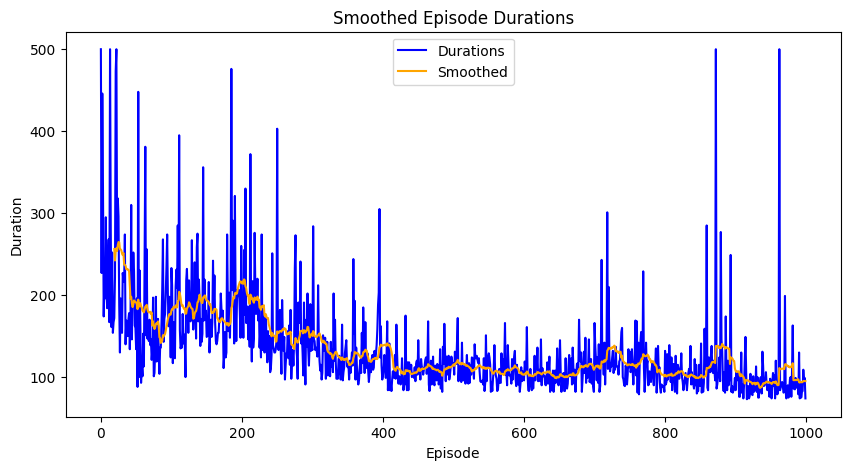

In [11]:
# @title Plotting and Smoothing Episode Durations Over Time

def plot_smooth_durations():
    if not episode_lengths:
        print("No durations to plot.")
        return

    window = 20
    smoothed = np.convolve(episode_lengths, np.ones(window) / window, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(episode_lengths, label='Durations', color='blue')
    plt.plot(range(window - 1, len(episode_lengths)), smoothed, label='Smoothed', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.title('Smoothed Episode Durations')
    plt.legend()
    plt.show()

plot_smooth_durations()

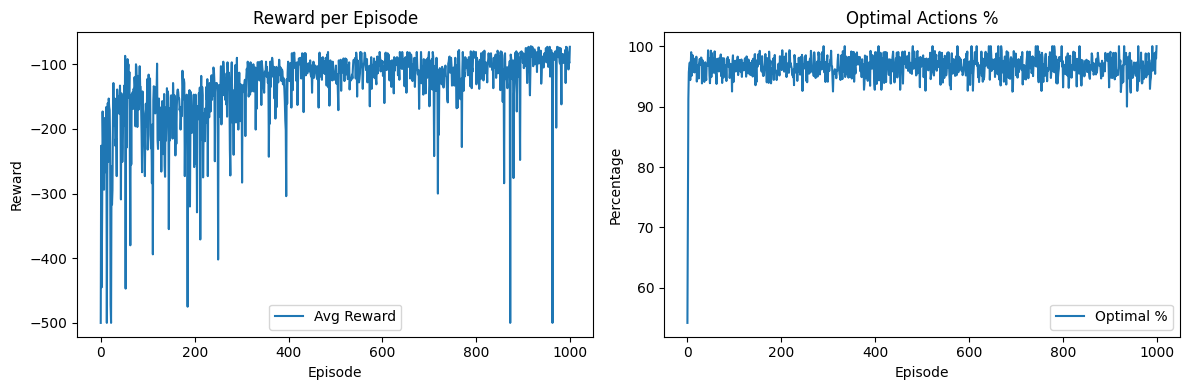

In [15]:
# @title Plotting Average Reward and Optimal Action Percentage from the Training Process

def plot_training_metrics():
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(12, 4))

    axis1.set_title("Reward per Episode")
    axis1.set_xlabel("Episode")
    axis1.set_ylabel("Reward")
    axis1.plot(rewards_log, label="Avg Reward")
    axis1.legend()

    axis2.set_title("Optimal Actions %")
    axis2.set_xlabel("Episode")
    axis2.set_ylabel("Percentage")
    axis2.plot(optimal_actions_log, label="Optimal %")
    axis2.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics()

In [16]:
# @title Showing An instance ( gif ) of Games played by Agents
def save_frames_as_gif(frames, filename="play.gif"):
    imageio.mimsave(filename, frames, duration=0.05)

def play_gif(filename):
    with open(filename, "rb") as file:
        display(Image(data=file.read(), format='png'))

# Generate GIF for the trained DQN network
frames_dqn = []
state = environment.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

policy_network.eval()
optimal_count_step = 0
randon_count_step = 0

for time_step in count():
    frame = environment.render(mode='rgb_array')
    frames_dqn.append(frame)
    action = choose_action(state)
    observation, reward, done, _ = environment.step(action.item())

    if done:
        optimal_count_step+= 1
        break
    else:
        optimal_count_step+= 1
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
save_frames_as_gif(frames_dqn, filename="ACROBOT_DQN.gif")

# Generate GIF for the random agent
frames_random = []
state = environment.reset()

for time_step in count():
    frame = environment.render(mode='rgb_array')
    frames_random.append(frame)
    action = environment.action_space.sample()  # Random action
    observation, reward, done, _ = environment.step(action)

    if done:
        randon_count_step+= 1
        break
    else:
        randon_count_step+= 1
        state = observation

save_frames_as_gif(frames_random, filename="ACROBOT_RANDOM.gif")


Trained DQN Agent:


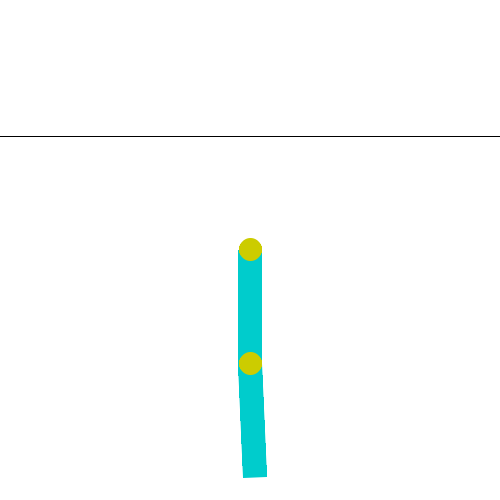

In [17]:
print("Trained DQN Agent:")
play_gif("ACROBOT_DQN.gif")

Random Agent:


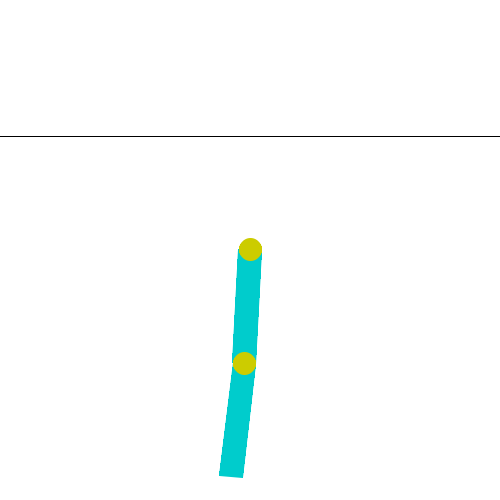

In [18]:
print("Random Agent:")
play_gif("ACROBOT_RANDOM.gif")

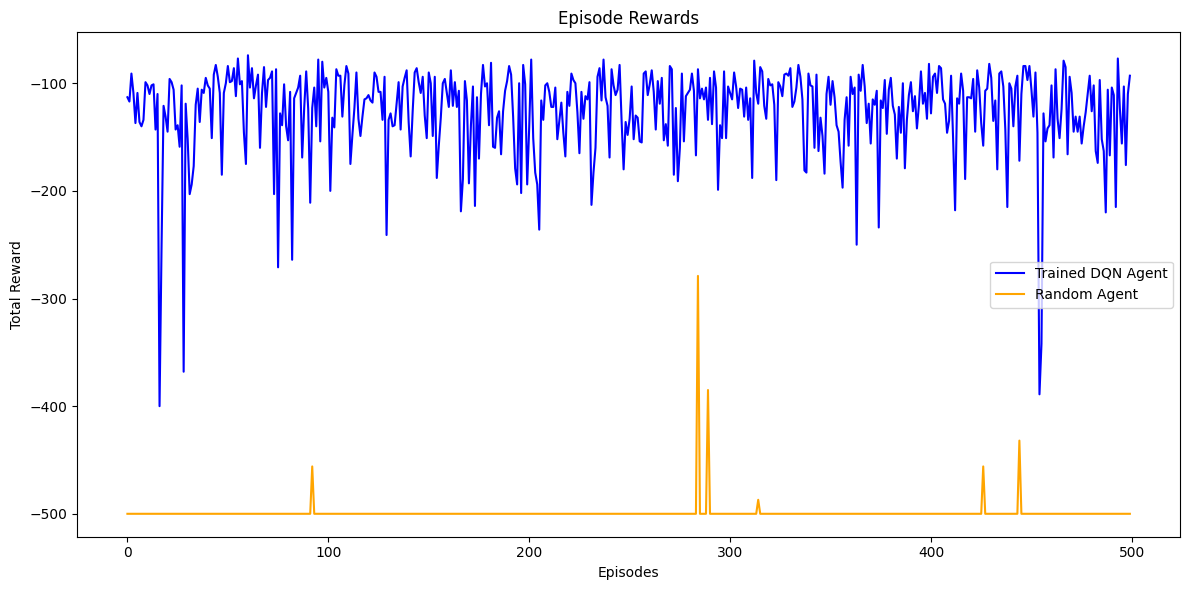

In [19]:
# @title Comparing Trained model with Random Agent

import matplotlib.pyplot as plt
import numpy as np

def evaluate_agent(agent_type, environment, policy_network=None, episodes=500):
    """Evaluate the performance of an agent (trained or random)."""
    episode_rewards = []
    for episode in range(episodes):
        state = environment.reset()
        total_reward = 0

        for t in count():
            if agent_type == "trained":
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                policy_network.eval()
                action = choose_action(state_tensor).item()
            elif agent_type == "random":
                action = environment.action_space.sample()

            next_state, reward, done, _ = environment.step(action)
            total_reward += reward

            if done:
                break
            state = next_state

        episode_rewards.append(total_reward)
    return episode_rewards

# Evaluate the trained DQN agent
trained_rewards = evaluate_agent("trained", environment, policy_network=policy_network)

# Evaluate the random agent
random_rewards = evaluate_agent("random", environment)

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(trained_rewards, label="Trained DQN Agent", color="blue")
plt.plot(random_rewards, label="Random Agent", color="orange")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.legend()
plt.tight_layout()
plt.show()


Trained Agent Average Reward: -125.73
Random Agent Average Reward: -498.99


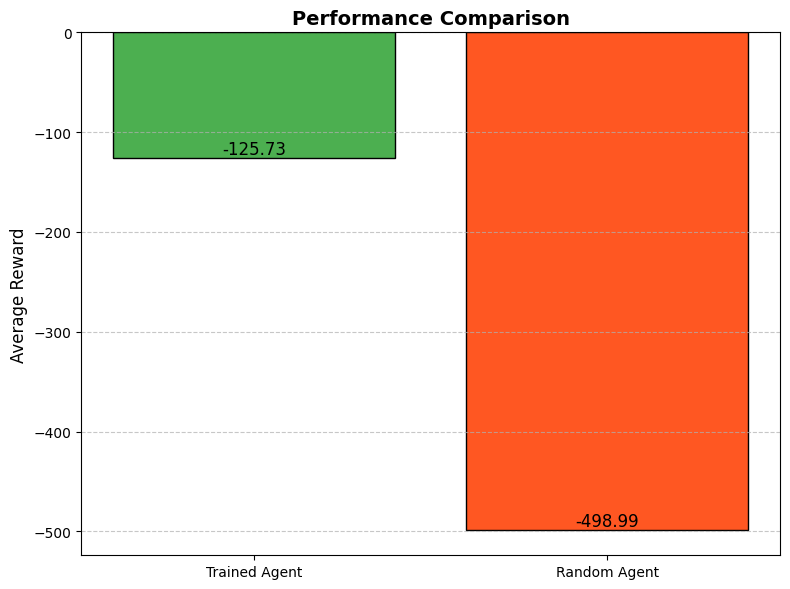

In [20]:
# @title Compare performance
trained_avg_reward = np.mean(trained_rewards)
random_avg_reward = np.mean(random_rewards)

# Print comparison with formatting
print(f"Trained Agent Average Reward: {trained_avg_reward:.2f}")
print(f"Random Agent Average Reward: {random_avg_reward:.2f}")

# Plot comparison with beautification
plt.figure(figsize=(8, 6))  # Increase figure size for better readability
bars = plt.bar(["Trained Agent", "Random Agent"], [trained_avg_reward, random_avg_reward], color=['#4CAF50', '#FF5722'], edgecolor='black')

# Add labels and title
plt.ylabel("Average Reward", fontsize=12)
plt.title("Performance Comparison", fontsize=14, fontweight='bold')

# Adding the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Grid and layout improvements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()